# Enhanced Sector ETF Portfolio Optimization with Multiple Strategies in Python with AMPL
[![Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb](https://img.shields.io/badge/github-%23121011.svg?logo=github)](https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb) [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb) [![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb) [![Gradient](https://assets.paperspace.io/img/gradient-badge.svg)](https://console.paperspace.com/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb) [![Open In SageMaker Studio Lab](https://studiolab.sagemaker.aws/studiolab.svg)](https://studiolab.sagemaker.aws/import/github/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb) [![Hits](https://h.ampl.com/https://github.com/ampl/colab.ampl.com/blob/master/authors/mukeshwaran/Notebook_3_Porfolio_Optimization_Sector_ETF.ipynb)](https://colab.ampl.com)

Description: This notebook compares multiple portfolio optimization strategies for invesment in Sector ETFs

Tags: finance, portfolio-optimization

Notebook author: Mukeshwaran Baskaran <<mukesh96official@gmail.com>>

In [38]:
# Install dependencies
%pip install amplpy yfinance seaborn matplotlib pandas numpy -q

In [39]:
# Google Colab & Kaggle integration
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gurobi"],  # modules to install
    license_uuid="default",  # license to use
)  # instantiate AMPL object and register magics

In [40]:
# Import libraries
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [41]:
# Define sector ETFs and fetch data
SECTOR_ETFS = [
    "XLK",  # Technology
    "XLF",  # Financials
    "XLV",  # Healthcare
    "XLE",  # Energy
    "XLY",  # Consumer Discretionary
    "XLC",  # Communication Services
    "VWO",  # Vanguard Emerging Markets (Global Exposure)
    "BND",  # Vanguard Total Bond Market ETF (Fixed Income)
    "GLD",  # SPDR Gold Shares (Commodity, Gold)
]

START_DATE = "2007-01-01"
END_DATE = "2020-01-01"

## Implementation

### Download historical data for sector ETFs

In [42]:
def fetch_sector_data(tickers, start_date, end_date):
    """Fetch historical data for given tickers."""
    data = yf.download(tickers, start=start_date, end=end_date)["Close"]
    if data.empty:
        raise ValueError("No data fetched. Check tickers and date range.")
    return data

### Calculate returns and covariance matrix

In [43]:
def calculate_statistics(data):
    """Calculate daily returns and covariance matrix."""
    returns = data.pct_change().dropna()
    cov_matrix = returns.cov().values
    mean_returns = returns.mean().values
    return returns, cov_matrix, mean_returns

### Minimum Variance Optimization using AMPL

In [44]:
def minimum_variance_optimization(tickers, cov_matrix):
    """Perform minimum variance optimization."""
    ampl = AMPL()
    ampl.eval(r"""
        set A ordered;  # Set of assets
        param S{A, A};  # Covariance matrix
        var w{A} >= 0 <= 1;  # Portfolio weights

        minimize min_variance:
            sum {i in A, j in A} w[i] * S[i, j] * w[j];  # Objective: minimize variance

        s.t. portfolio_weights:
            sum {i in A} w[i] = 1;  # Constraint: weights sum to 1
    """)
    ampl.set["A"] = tickers
    ampl.param["S"] = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
    ampl.solve(solver="gurobi", mp_options="outlev=1")
    return pd.Series(ampl.var["w"].to_dict())

### Markowitz (Mean-Variance) Optimization using AMPL


In [45]:
def markowitz_optimization(tickers, cov_matrix, mean_returns, risk_tolerance):
    """Perform Markowitz mean-variance optimization."""
    ampl = AMPL()
    ampl.eval("""
        set A ordered;  # Set of assets
        param S{A, A};  # Covariance matrix
        param mu{A};    # Expected returns
        param gamma;    # Risk tolerance
        var w{A} >= 0 <= 1;  # Portfolio weights

        maximize expected_return:
            sum {i in A} mu[i] * w[i];  # Objective: maximize expected return

        s.t. portfolio_weights:
            sum {i in A} w[i] = 1;  # Constraint: weights sum to 1

        s.t. risk_constraint:
            sum {i in A, j in A} w[i] * S[i, j] * w[j] <= gamma;  # Risk constraint
    """)
    ampl.set["A"] = tickers
    ampl.param["S"] = pd.DataFrame(cov_matrix, index=tickers, columns=tickers)
    ampl.param["mu"] = pd.Series(mean_returns, index=tickers)
    ampl.param["gamma"] = risk_tolerance
    ampl.solve(solver="gurobi", mp_options="outlev=1")
    return pd.Series(ampl.var["w"].to_dict())

### Equal-Weighted Portfolio

In [46]:
def equal_weighted_portfolio(tickers):
    """Equal-weighted portfolio."""
    n_assets = len(tickers)
    return pd.Series(np.ones(n_assets) / n_assets, index=tickers)

### Plot portfolio weights comparison

In [47]:
def plot_weights_comparison(weights_dict):
    """Plot comparison of portfolio weights across strategies."""
    weights_df = pd.DataFrame(weights_dict)
    weights_df.plot(kind='bar', figsize=(14, 7), colormap='viridis')
    plt.title('Portfolio Weights Comparison', fontsize=18, fontweight='bold')
    plt.xlabel('Asset')
    plt.ylabel('Weight')
    plt.xticks(rotation=0)
    plt.grid(True)
    plt.show()

### Plot cumulative returns

In [48]:
def plot_cumulative_returns(returns, weights_dict):
    """Plot cumulative returns for each strategy."""
    plt.figure(figsize=(14, 7))
    for strategy, weights in weights_dict.items():
        portfolio_returns = returns.dot(weights)
        cumulative_returns = (1 + portfolio_returns).cumprod() - 1
        plt.plot(cumulative_returns, label=strategy)
    plt.title('Cumulative Returns by Strategy', fontsize=18, fontweight='bold')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()

### Plot correlation matrix

In [49]:
def plot_correlation_matrix(returns):
    """Plot correlation matrix of asset returns."""
    plt.figure(figsize=(10, 8))
    sns.heatmap(returns.corr(), annot=True, cmap='coolwarm', center=0)
    plt.title('Correlation Matrix of Asset Returns', fontsize=16, fontweight='bold')
    plt.show()

### Calculate portfolio performance metrics

In [50]:
def calculate_performance_metrics(returns, weights, risk_free_rate=0):
    """Calculate portfolio performance metrics."""
    portfolio_returns = returns.dot(weights)
    cumulative_returns = (1 + portfolio_returns).cumprod() - 1
    annualized_return = portfolio_returns.mean() * 252
    annualized_volatility = portfolio_returns.std() * np.sqrt(252)
    sharpe_ratio = (annualized_return - risk_free_rate) / annualized_volatility
    sortino_ratio = (annualized_return - risk_free_rate) / (portfolio_returns[portfolio_returns < 0].std() * np.sqrt(252))
    max_drawdown = (cumulative_returns / cumulative_returns.cummax() - 1).min()
    return {
        "Annualized Return": annualized_return,
        "Annualized Volatility": annualized_volatility,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Max Drawdown": max_drawdown
    }

## Execution

### Fetch data

In [51]:
sector_data = fetch_sector_data(SECTOR_ETFS, START_DATE, END_DATE)

[*********************100%***********************]  9 of 9 completed


### Calculate statistics

In [52]:
returns, cov_matrix, mean_returns = calculate_statistics(sector_data)

### Optimize portfolios using AMPL

In [53]:
# Equal weights
equal_weights = equal_weighted_portfolio(SECTOR_ETFS)

# Minimum variance
min_var_weights = minimum_variance_optimization(SECTOR_ETFS, cov_matrix)

# Markowitz Optimization (Mean-Variance)
risk_tolerance = 0.01  # Set risk tolerance (gamma)
markowitz_weights = markowitz_optimization(SECTOR_ETFS, cov_matrix, mean_returns, risk_tolerance)

Gurobi 12.0.1: Set parameter LogToConsole to value 1
  tech:outlev = 1

AMPL MP initial flat model has 9 variables (0 integer, 0 binary);
Objectives: 1 quadratic; 
Constraints:  1 linear;

AMPL MP final model has 9 variables (0 integer, 0 binary);
Objectives: 1 quadratic; 
Constraints:  1 linear;


Set parameter InfUnbdInfo to value 1
Gurobi Optimizer version 12.0.1 build v12.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
InfUnbdInfo  1

Optimize a model with 1 rows, 9 columns and 9 nonzeros
Model fingerprint: 0xfb514690
Model has 45 quadratic objective terms
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [0e+00, 0e+00]
  QObjective range [7e-06, 5e-04]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Presolve time: 0.01s
Presolved: 1 rows, 9 columns, 9 nonzeros
Presolve

### Compare portfolio weights

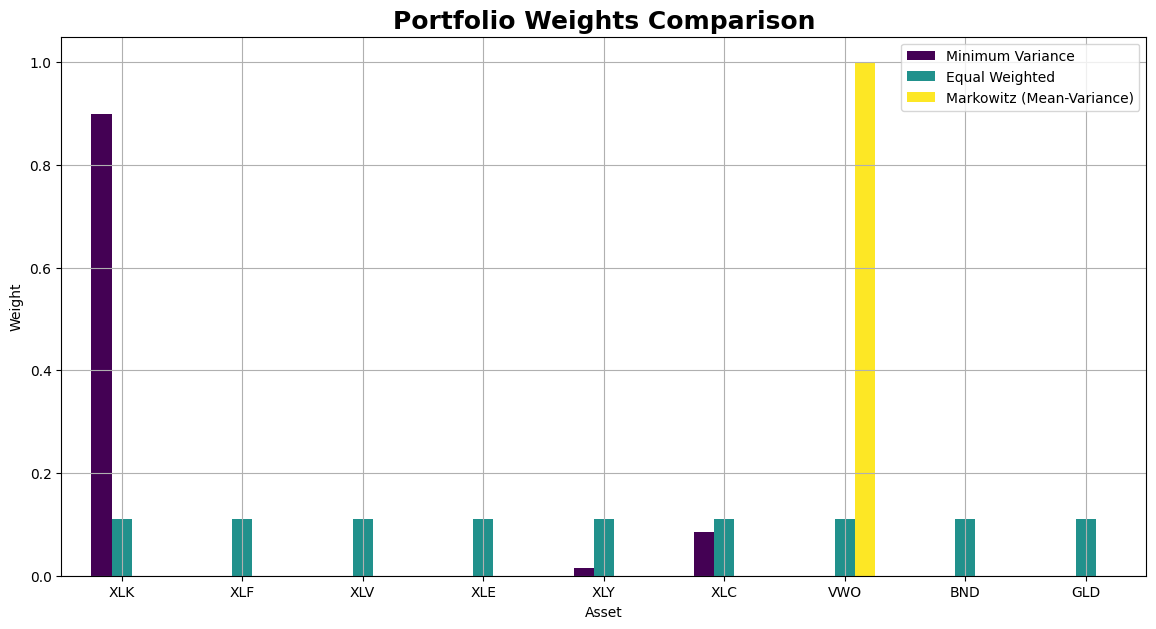

In [54]:
weights_dict = {
    "Minimum Variance": min_var_weights,
    "Equal Weighted": equal_weights,
    "Markowitz (Mean-Variance)": markowitz_weights,
}
plot_weights_comparison(weights_dict)

### Plot cumulative returns

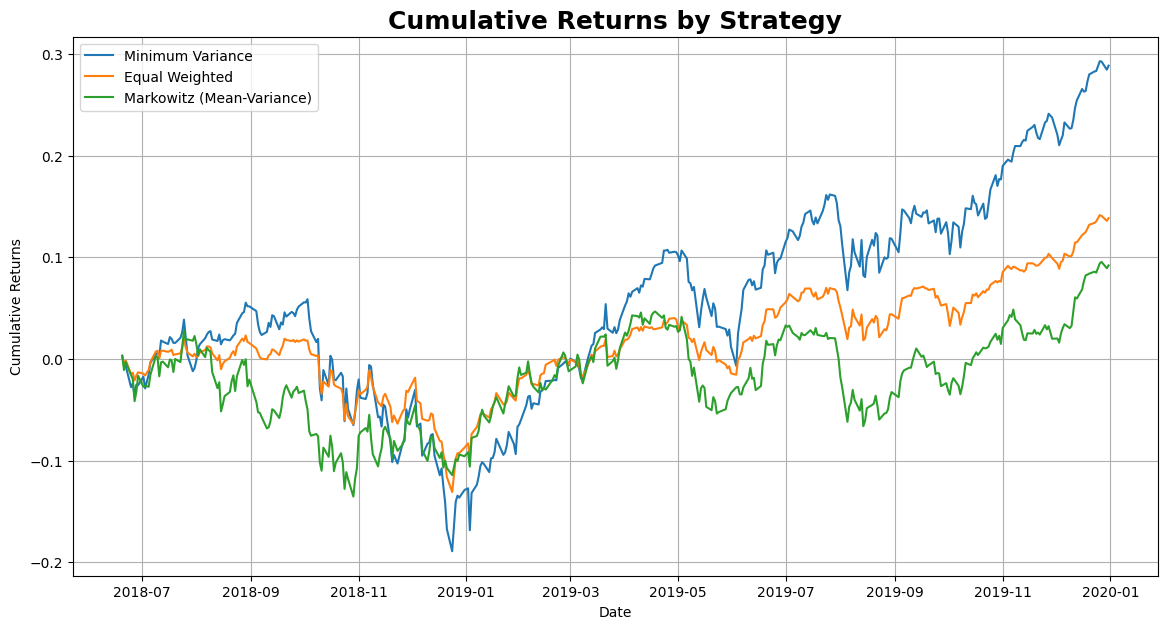

In [55]:
plot_cumulative_returns(returns, weights_dict)

### Plot correlation matrix

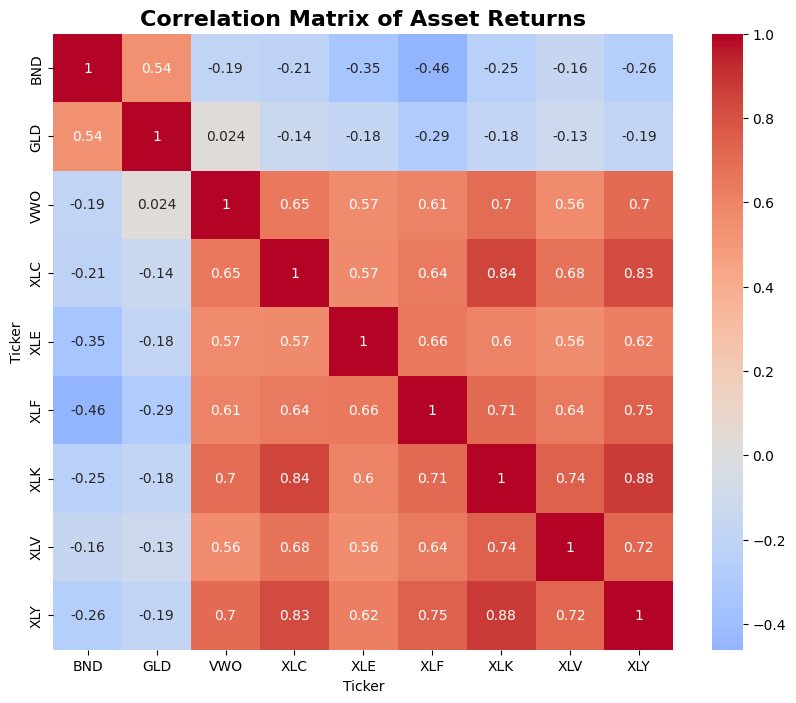

In [56]:
plot_correlation_matrix(returns)

### Compare performance metrics

In [57]:
performance_metrics = {}
for strategy, weights in weights_dict.items():
    performance_metrics[strategy] = calculate_performance_metrics(returns, weights)

performance_df = pd.DataFrame(performance_metrics).T
print(performance_df)

                           Annualized Return  Annualized Volatility  \
Minimum Variance                    0.186117               0.203196   
Equal Weighted                      0.091404               0.116153   
Markowitz (Mean-Variance)           0.071822               0.169583   

                           Sharpe Ratio  Sortino Ratio  Max Drawdown  
Minimum Variance               0.915950       1.149967    -13.204538  
Equal Weighted                 0.786927       1.033226    -10.613445  
Markowitz (Mean-Variance)      0.423524       0.605596    -13.811130  


### Plot performance metrics

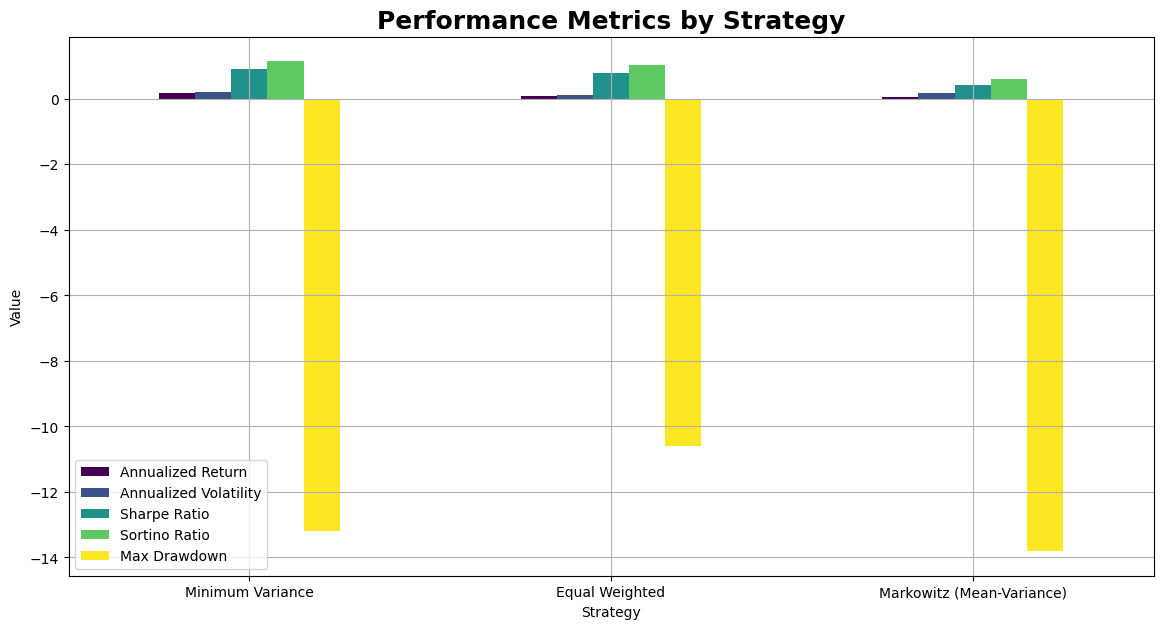

In [58]:
performance_df.plot(kind='bar', figsize=(14, 7), colormap='viridis')
plt.title('Performance Metrics by Strategy', fontsize=18, fontweight='bold')
plt.xlabel('Strategy')
plt.ylabel('Value')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()